# Image Captioning Model

### This project involved the use of a modified pre-trained ResNet50 model to map english words to the input image’s features to produce a caption through text generators (of GloVe word embedding).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/encoded-train-imagespkl/encoded_train_images.pkl
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/encoded-test-images/encoded_test_images.pkl
/kaggle/input/style-pictures/me_fire.PNG
/kaggle/input/glove6b200d/glove.6B.200d.txt
/kaggle/input/pictures/me.jpg


In [2]:
# Importing the Required Libraries

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.preprocessing import image
import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import *
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import datetime
import tensorflow as tf
import cv2


In [3]:
#reading the image captioning data file using pandas

dataset = pd.read_csv('../input/flickr8k/captions.txt',delimiter=',',header=None)
dataset=dataset[1:]

### Text Pre-processing

The text data has been preprocessed using a regular expression library in which the text is in lower case and has been joined with the start and end sequence tags. 


In [4]:
# Libraries to be used for data cleaning/text preprocessing

import re
import nltk


corpus = []
for i in range(1, dataset.shape[0]):
    cap = re.sub('[^a-zA-Z]', ' ', dataset[1][i])  #Removed all other characters except alphabets
    cap = cap.lower()                              #Converted to lower case
    cap = cap.split()                              # split the text into individual tokens in a list 
    cap=[word for word in cap if len(word)>1]      #Removed single letter words
    cap = ' '.join(cap)                            # Joined with spaces
    cap= '<startseq> '+cap+' <endseq>'             # Putting the start and end sequence tags
    corpus.append(cap)                             #list of captions


### I’ve made the use of the dictionary as a key-value pair look-up data structure in which the key is the image filename and the corresponding value is the set of 5 captions. Dictionary is a hash table which has constant search time (i.e. O(1) ) while looking up for the elements. 

In [5]:
# Joins the Images to its captions using a dictionary; key-value pair as image file name and corresponding 5 captions

from collections import defaultdict
new_dict= defaultdict(lambda : [])          #Created a dictionary with image ids as key and captions as value
i=1
while i <len(corpus):
  # print(dataset[0][i])
  new_dict[dataset[0][i]].append(corpus[i-1])
  i=i+1

In [6]:
print(new_dict['1000268201_693b08cb0e.jpg'])

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>', '<startseq> girl going into wooden building <endseq>', '<startseq> little girl climbing into wooden playhouse <endseq>', '<startseq> little girl climbing the stairs to her playhouse <endseq>', '<startseq> little girl in pink dress going into wooden cabin <endseq>']


In [7]:
all_vocab = []              #a list of all the words in the captions

for key in new_dict.keys():
    [ all_vocab.append(i) for des in new_dict[key] for i in des.split()]

In [8]:
print("total words appearing : " , len(all_vocab)) # vocabulary -- total unique words

total words appearing :  454697


### The wordcount has been built using Counter library and the vocabulary to be used for the image captioning has been trimmed based on the word frequency threshold value.

In [9]:
from collections import Counter

counter = Counter(all_vocab) # creating word count

In [10]:
dic_ = dict(counter)

In [11]:
sorted_dic = sorted(dic_.items(), key = lambda x: x[1], reverse=True)   #sort with words and their corresponding frequency in descending order

In [12]:
# we decide upon a threshold value which helps in selecting the words that occur more than others in the corpus
# Here we choose a threshold of 10, so that words that occur more than 10 times in the entire corpus are chosen

threshold_value = 10

d = [(x) for x in sorted_dic if x[1]>threshold_value]

In [13]:
all_vocab = [x[0] for x in d]  #Updating all_vocab

In [14]:
image_ids=[]
j=1
for i in range(0,len(dataset)//5 ):
    image_ids.append(dataset[0][j])
    j=j+5
## data has been trimmed down by 1/25th for the computation purposes

In [15]:
new_dict[image_ids[0]]

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
 '<startseq> girl going into wooden building <endseq>',
 '<startseq> little girl climbing into wooden playhouse <endseq>',
 '<startseq> little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> little girl in pink dress going into wooden cabin <endseq>']

In [16]:
split_train_to_test_ratio=0.8
train_end=int(split_train_to_test_ratio*len(image_ids))

train=image_ids[0:train_end]
test=image_ids[train_end:]

In [17]:
train_descriptions = {}               #dictionary with keys as image ids and values as corresponding captions
#ding captions
for t in train:
    train_descriptions[t] = []
    for cap in new_dict[t]:
        train_descriptions[t].append(cap)

In [18]:
test_descriptions = {}             #dictionary with keys as image ids and values as corresponding captions
for t in test:
    test_descriptions[t] = []
    for cap in new_dict[t]:
        test_descriptions[t].append(cap)

### Importing Resnet pretrained model on ImageNet that can be used as a feature extractor. Therefore we have to remove the classifier layer so that the end layer of the model gives out the features rather than the class labels.

In [19]:
from keras.applications.resnet50 import ResNet50, preprocess_input

model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))

model.summary()

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [20]:
model_new = Model(inputs = model.input, outputs =  model.layers[-2].output) # the classfication layer has been removed; using the model as feature extractor
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [21]:

def preprocess_image(img):
    '''
    input: image
    output: pre-processed image
    This function preprocesses the images to be fed into the model
    '''
    
    img = image.load_img(img, target_size=(224,224)) #load the image and resize to 224, 244 so that it can be passed into ResNet as an input
    img = image.img_to_array(img) # convert to numpy array
    img = preprocess_input(img) 
    img = np.expand_dims(img, axis = 0)

    return img

In [22]:
def encode_image(img):
    '''
    input: image
    output: extracted features
    This function uses the Resnet model to give out the extracted feature
    '''
    
    img = preprocess_image(img)
    fea_vec = model_new.predict(img) # feature extraction by ResNet
    fea_vec = fea_vec.reshape(fea_vec.shape[1], )
    return fea_vec # feature vector of the image

In [23]:

images='../input/flickr8k/Images/'

 # Obtaining Feature vector from training images. Here we use the encode_image function on every images
 
start = time.time()

encoding_train = {}                #Dictionary with keys as image ids and values as encoding corresponding to the images                        

for ix, img in enumerate(train):
    
    img = images+train[ix]#+".jpg"
    
    p = encode_image(img)
    
    encoding_train[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + str(time.time() - start))


'\nimages=\'../input/flickr8k/Images/\'\n\n # Obtaining Feature vector from training images\n \nstart = time.time()\n\nencoding_train = {}                #Dictionary with keys as image ids and values as encoding corresponding to the images                        \n\nfor ix, img in enumerate(train):\n    \n    img = images+train[ix]#+".jpg"\n    \n    p = encode_image(img)\n    \n    encoding_train[ img[len(images):] ] = p\n    \n    \n    if ix%100 == 0:\n        print("Encoding image :" + str(ix))\n    \nprint("Time taken in sec - " + str(time.time() - start))\n'

In [24]:

# Obtaining Feature vector from test images

start = time.time()

encoding_test = {}

for ix, img in enumerate(test):
    
    img = images+test[ix]#+".jpg"
    
    p = encode_image(img)
    
    encoding_test[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + str(time.time() - start))

'\n# Obtaining Feature vector from test images\n\nstart = time.time()\n\nencoding_test = {}\n\nfor ix, img in enumerate(test):\n    \n    img = images+test[ix]#+".jpg"\n    \n    p = encode_image(img)\n    \n    encoding_test[ img[len(images):] ] = p\n    \n    \n    if ix%100 == 0:\n        print("Encoding image :" + str(ix))\n    \nprint("Time taken in sec - " + str(time.time() - start))\n'

# The processing time to get the flick8r feature vector is really long. Therefore, I’ve used pickle and serialized these variables like `encoding_train` variable which takes a long to process and save it to the workspace. So that we can pick up the work where you left off in the last session without having to re-run all the variables again.

In [25]:

with open("../input/encoded-train-imagespkl/encoded_train_images.pkl", 'wb') as f:
    pickle.dump(encoding_train, f )

In [26]:
with open("encoded_test_images.pkl", 'wb') as f:
    pickle.dump(encoding_test, f )


In [27]:
with open("../input/encoded-train-imagespkl/encoded_train_images.pkl", 'rb') as f:
    encoding_train = pickle.load(f)

In [28]:
with open("../input/encoded-test-images/encoded_test_images.pkl", 'rb') as f:
    encoding_test = pickle.load(f)

### Creating dictionary for lookup of the word and their indices and vice versa. Dictionary is a python hash table which has constant search time (i.e. O(1) ) while looking up for the element.

In [29]:
word_to_idx = {}
idx_to_word = {}

ix = 1

for e in all_vocab:
    #print(ix,e)
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [30]:
vocab_size = len(idx_to_word) + 1 # vocabulary size
print(vocab_size)

1848


In [31]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))

In [32]:
max_len = max(all_caption_len) # maximum sequence length. This will be required to decide on the amount of padding
print(max_len) 

35


In [33]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len,  num_photos_per_batch ):
    '''
    This is a generator function to efficiently pass the data in batch to train the model and
    then the batch data is removed from the memory after the iteration. 
    Python generators make batch training less memory intensive. 
    '''
    X1, X2, y = [], [], []
    
    n=0
    cnt = 0
    all_items = list(train_descriptions.keys())
    
    while True:
      n+=1
      # print(cnt)
      key = all_items[cnt]
      desc_list = train_descriptions[key]              
      cnt+=1
      cnt= (cnt%len(all_items))
        
      photo = encoding_train[key]#+".jpg"]          #feature vector
            #print(photo.shape)
      for desc in desc_list:                       #desc : iterates through the 5 captions
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]                
                
        for i in range(1, len(seq)): 
            in_seq = seq[0:i]
            out_seq = seq[i]
            
            in_seq = pad_sequences( [in_seq], maxlen=max_len, value= 0, padding='post')[0]
        
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)

      if n == num_photos_per_batch:
          yield [np.array(X1), np.array(X2)] , np.array(y)
          X1, X2, y = [], [], []
          n = 0         

In [34]:
key="1000268201_693b08cb0e"
print(key)
print(encoding_train[key+".jpg"])

1000268201_693b08cb0e
[0.06535925 0.16782555 0.3251761  ... 0.05107139 0.32821202 1.0043362 ]


In [35]:
embeddings = {}
# word embedding for the vector representation of the tokens using the pre-trained glove word embedding
with open("../input/glove6b200d/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype="float32")
        
        embeddings[word] = coeffs

In [36]:
def getOutputEmbeddings():
    '''
    This function is used to get the word from the given text data and 
    assign the corresponding vector representation taken from the glove model 
    '''

    emb_dim = 200 # having low dimensional vector size
    embedding_matrix_output = np.zeros((vocab_size, emb_dim )) # initialize the embedding matrix 
    
    for word, idx in word_to_idx.items():
        
        emb_vec = embeddings.get(word)
        
        if emb_vec is not None:
            embedding_matrix_output[idx] = emb_vec # assigning the word idx with the embedding vector 
            
    return embedding_matrix_output

In [37]:
embedding_output = getOutputEmbeddings()
embedding_output.shape


(1848, 200)

In [38]:
#image feature extraction
input_img_fea = Input(shape=(2048,))

#with dropout and relu --- experiment 1
inp_img1 = Dropout(0.3)(input_img_fea) #to prevent overfitting
inp_img2 = Dense(256, activation='relu')(inp_img1) # 

#Without dropout, with relu ---experiment 2
#inp_img2 = Dense(256, activation='relu')(input_img_fea) # 

In [39]:
print(inp_img2.shape)

(None, 256)


In [40]:
#caption text processing using embedding and then further learning with LSTM
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim= vocab_size, output_dim=200, mask_zero=True)(input_cap)

##with dropout -- experiement 1 and 3
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

#without dropout, with relu --- experiment 2
#inp_cap3 = LSTM(256)(inp_cap1)


In [41]:
print(inp_cap3.shape)

(None, 256)


In [42]:
decoder1 = add([inp_img2, inp_cap3]) #concatenating the processed image features and processed captions
print(decoder1.shape)

#with relu --- experiment 1 and 2
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

#with sigmoid ---experiment 3
#decoder2 = Dense(256, activation='sigmoid')(decoder1)


model = Model(inputs = [input_img_fea, input_cap]  , outputs =  output )

(None, 256)


In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 200)      369600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [44]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [45]:
model.compile(loss="categorical_crossentropy", optimizer='adam') 


### Training of the LSTM decoder

In [47]:
epochs = 30
number_photos_per_batch = 3
steps = len(train_descriptions)//number_photos_per_batch

mytraingen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_photos_per_batch)

history = model.fit(mytraingen,steps_per_epoch=steps,epochs = epochs)
model.save(filepath="best_model1.h5")

Epoch 1/30
2157/2157 [==============================] - 37s 15ms/step - loss: 4.0697
Epoch 2/30
2157/2157 [==============================] - 32s 15ms/step - loss: 3.3517
Epoch 3/30
2157/2157 [==============================] - 33s 15ms/step - loss: 3.1230
Epoch 4/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.9784
Epoch 5/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.8735
Epoch 6/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.7912
Epoch 7/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.7256
Epoch 8/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.6660
Epoch 9/30
2157/2157 [==============================] - 33s 15ms/step - loss: 2.6229
Epoch 10/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.5806
Epoch 11/30
2157/2157 [==============================] - 32s 15ms/step - loss: 2.5456
Epoch 12/30
2157/2157 [==============================] - 32s 15

In [54]:
model.history

In [55]:
model.save_weights("weights1.h5") 


In [56]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-py3-none-any.whl size=8612 sha256=8256cd2e488d395a8417b117c45cf28a7df93d46959c117b40dbfd5b603dcfb8
  Stored in directory: /root/.cache/pip/wheels/9e/2e/42/17cb826d143226e4d081aa33d3a9b9a90f234dfcf409824b87
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=d1fcbbefa8291cfc523a1aa06236eb64fe5ac64ef746e49ca312b98308333fe4
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4587 sha256=7dc60d5c151fa0f785e88b7faf19790f11923c02de5191a970bccd7a40dae628
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' com

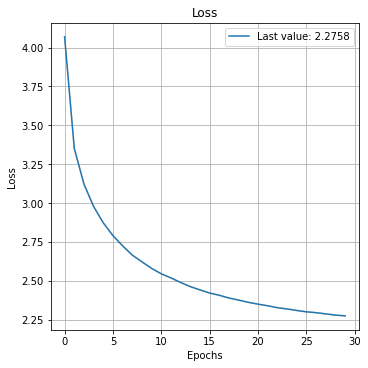

In [58]:
from plot_keras_history import plot_history

plot_history(model.history, path="standard.png")
plt.show()

In [59]:
def predict(photo_enc,model):
    '''
    input arg1: photo encoded by the pre-trained model ie. feature extracted by the pre-trained ResNet
    input arg2: LSTM decoder
    output: Caption of the image
    This function generates the captions'''
    in_text = "<startseq>"
    
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        y_pred = model.predict([photo_enc, sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word[y_pred]
        
        in_text += " "+word
        
        if word == '<endseq>':
            break
        
        
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

In [60]:
#model=load_model("../input/best_model1.h5")


### Image Captioning displays

(2048,)
(1, 2048)
3601978895_9fec23ce0c
3601978895_9fec23ce0c.jpg
BLEU Score for image id : 3601978895_9fec23ce0c.jpgis : 0.668740304976422
prediction: man lays on bench with his hand up to him
(500, 374, 3)


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


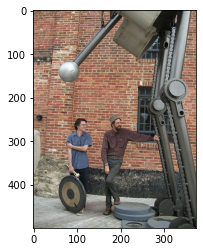

In [61]:
scores=[]
images='../input/flickr8k/Images/'

rn = 3
img_id = list(encoding_test.keys())[rn]
print(encoding_test[img_id].shape)
photo_enc = encoding_test[img_id].reshape((1,2048))
print(photo_enc.shape)
sh_img_id=img_id[:-4]
print(sh_img_id)
reference=new_dict[sh_img_id+'.jpg']
#print(new_dict['1001773457_577c3a7d70.jpg'])
references=[]
print(img_id)

for ref in reference:
    ref=ref[11:-9]
    ref=ref.split(' ')
    references.append(ref)
pred = predict(photo_enc,model)
translation=pred.split(' ')
#print(translation)
#print(reference)
score1 = sentence_bleu(references, translation)
scores.append(score1)
print("BLEU Score for image id : "+img_id+"is : "+str(score1))
print('prediction: '+ pred)
path = images + img_id
img = plt.imread(path)
print(img.shape)
plt.imshow(img)
plt.show()

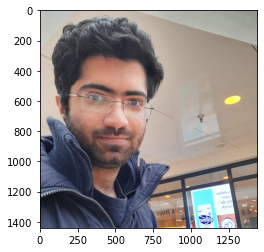

In [62]:
img2 = plt.imread('../input/pictures/me.jpg')
plt.imshow(img2)
plt.show()

In [63]:
photo_enc = encode_image('../input/pictures/me.jpg').reshape((1,2048)) 
predict(photo_enc,model)

'man with sunglasses and glasses is speaking'

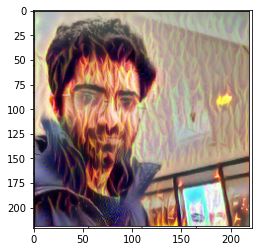

In [64]:
style_img = plt.imread('../input/style-pictures/me_fire.PNG')
plt.imshow(style_img)
plt.show()

In [65]:
photo_enc = encode_image('../input/style-pictures/me_fire.PNG').reshape((1,2048)) 
predict(photo_enc,model)

'man in black hat and gold chain is cooking'